# The Mixtape with PyFixest

In this notebook, we translate some of the Python code in [Scott Cunningham's mixtape](https://mixtape.scunning.com/) to PyFixest.

In [1]:
import re

import numpy as np
import pandas as pd

import pyfixest as pf

## Chapter 8: Panel Data

Instead of demeaning by hand and then fitting the model via statsmodels, we just let PyFixest do all the work for us. 

In [2]:
# read the data from github & load into pandas
url = "https://raw.githubusercontent.com/scunning1975/mixtape/master/sasp_panel.dta"
sasp = pd.read_stata(url)
sasp.head()

,id,session,age,age_cl,appearance_cl,bmi,schooling,asq_cl,provider_second,asian_cl,...,hispanic,other,white,asq,cohab,married,divorced,separated,nevermarried,widowed
0,243.0,2.0,27.0,30.0,5.0,NaN,11.0,900.0,1. No,0.0,...,0.0,0.0,0.0,729.0,1.0,0.0,0.0,0.0,0.0,0.0
1,397.0,4.0,28.0,56.0,5.0,28.971931,16.0,3136.0,1. No,0.0,...,0.0,0.0,1.0,784.0,0.0,1.0,0.0,0.0,0.0,0.0
2,598.0,4.0,50.0,52.0,6.0,21.453857,16.0,2704.0,1. No,0.0,...,0.0,0.0,1.0,2500.0,0.0,0.0,1.0,0.0,0.0,0.0
3,28.0,1.0,41.0,72.0,5.0,24.028320,12.0,5184.0,1. No,0.0,...,0.0,0.0,1.0,1681.0,0.0,0.0,1.0,0.0,0.0,0.0
4,28.0,4.0,41.0,46.0,8.0,24.028320,12.0,2116.0,1. No,0.0,...,0.0,0.0,1.0,1681.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
# some initial data cleaning
sasp = sasp.dropna()
# order by id and session
sasp.sort_values("id", inplace=True)

# create balanced panel
times = len(sasp.session.unique())
in_all_times = (
    sasp.groupby("id")["session"].apply(lambda x: len(x) == times).reset_index()
)
in_all_times.rename(columns={"session": "in_all_times"}, inplace=True)
balanced_sasp = pd.merge(in_all_times, sasp, how="left", on="id")
balanced_sasp = balanced_sasp[balanced_sasp.in_all_times]

provider_second = np.zeros(balanced_sasp.shape[0])
provider_second[balanced_sasp.provider_second == "2. Yes"] = 1
balanced_sasp.provider_second = provider_second

In [4]:
# define formulas

covars = """
    age + asq + bmi + hispanic + black + other + asian + schooling + cohab +
            married + divorced + separated + age_cl + unsafe + llength + reg + asq_cl +
            appearance_cl + provider_second + asian_cl + black_cl + hispanic_cl +
           othrace_cl + hot + massage_cl
    """

# we fit on all covariates
fml_pooled = f"lnw ~ {covars}"
# we fit on all covariates and add one-hot encoded id fixed effects
fml_onehot = f"lnw ~  {covars} + C(id)"
# we fit on all covariates and swipe out the fixed effects (i.e. we apply the within transformation via pyfixest.feols)
fml_fe = f"lnw ~ {covars} | id"

In [5]:
%%capture
fit_pooled = pf.feols(fml=fml_pooled, data=balanced_sasp, vcov={"CRV1": "id"})
fit_fe = pf.feols(fml=fml_fe, data=balanced_sasp, vcov={"CRV1": "id"})

In [6]:
pf.etable(
    [fit_pooled, fit_fe],
    model_heads=["POLS", "FE"],
    keep=["unsafe", "llength", "reg"],
    labels={
        "unsafe": "Unprotected sex with client of any kind",
        "llength": "Ln(Length)",
        "reg": "Client was a Regular",
    },
    digits=6,
)

GT(_tbl_data=  level_0                                  level_1  \
0    coef  Unprotected sex with client of any kind   
1    coef                               Ln(Length)   
2    coef                     Client was a Regular   
3      fe                                       id   
4   stats                             Observations   
5   stats                                S.E. type   
6   stats                            R<sup>2</sup>   
7   stats                     R<sup>2</sup> Within   

                              0                             1  
0      0.013407 <br> (0.042455)      0.051034 <br> (0.028283)  
1  -0.308251*** <br> (0.040905)  -0.434506*** <br> (0.024323)  
2     -0.047007 <br> (0.033282)    -0.037341* <br> (0.018761)  
3                             -                             x  
4                          1028                          1028  
5                        by: id                        by: id  
6                      0.302643                      0.832214  
7                             -                      0.515959  , _body=<great_tables._gt_data.Body object at 0x000002262B9D89B0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000022632EF5790>, _spanners=Spanners([SpannerInfo(spanner_id='lnw', spanner_level=2, spanner_label='lnw', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None), SpannerInfo(spanner_id='POLS', spanner_level=1, spanner_label='POLS', spanner_units=None, spanner_pattern=None, vars=['0'], built=None), SpannerInfo(spanner_id='FE', spanner_level=1, spanner_label='FE', spanner_units=None, spanner_pattern=None, vars=['1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000022632EF5730>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo

Note that standard errors differ slightly due to differences in small sample adjustments in Stata and Pyfixest. See [here](https://py-econometrics.github.io/pyfixest/ssc.html)
for an overview of how pyfixest handles small sample adjustments. 

## Chapter 9: Difference-in-Differences

### Code Example 1

In [7]:
abortion = pd.read_stata(
    "https://raw.githubusercontent.com/scunning1975/mixtape/master/abortion.dta"
)
abortion = abortion[~pd.isnull(abortion.lnr)]
abortion_bf15 = abortion[abortion.bf15 == 1]
# pf throws error when weights are 0
abortion_bf15 = abortion_bf15[abortion_bf15.totpop > 0]
abortion_bf15.head()

,fip,age,race,year,sex,totcase,totpop,rate,totrate,id,...,female,lnr,t,younger,fa,pi,wm15,wf15,bm15,bf15
19,1.0,15.0,2.0,1985.0,2,5683.0,106187,6527.500000,5351.899902,14.0,...,1.0,8.783779,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
39,1.0,15.0,2.0,1986.0,2,5344.0,106831,6351.200195,5002.299805,14.0,...,1.0,8.756399,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
71,1.0,15.0,2.0,1987.0,2,4983.0,106496,5759.100098,4679.000000,14.0,...,1.0,8.658537,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
89,1.0,15.0,2.0,1988.0,2,5276.0,105238,6139.600098,5013.399902,14.0,...,1.0,8.722515,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
106,1.0,15.0,2.0,1989.0,2,5692.0,102956,5951.500000,5528.600098,14.0,...,1.0,8.691399,5.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [8]:
def _extract_bracket_numbers(str_list) -> dict:
    "Extract time from event study coefficients and store in dict."
    out = {}
    pattern = re.compile(r"\[(\d+\.?\d*)\]")  # capture numbers inside []

    for s in str_list:
        match = pattern.search(str(s))  # convert np.str_ -> str
        if match:
            out[s] = match.group(1)
    return out

C:\Users\alexa\Documents\pyfixest\pyfixest\estimation\feols_.py:2759: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['C(fip)[T.53.0]'].
            
  warnings.warn(


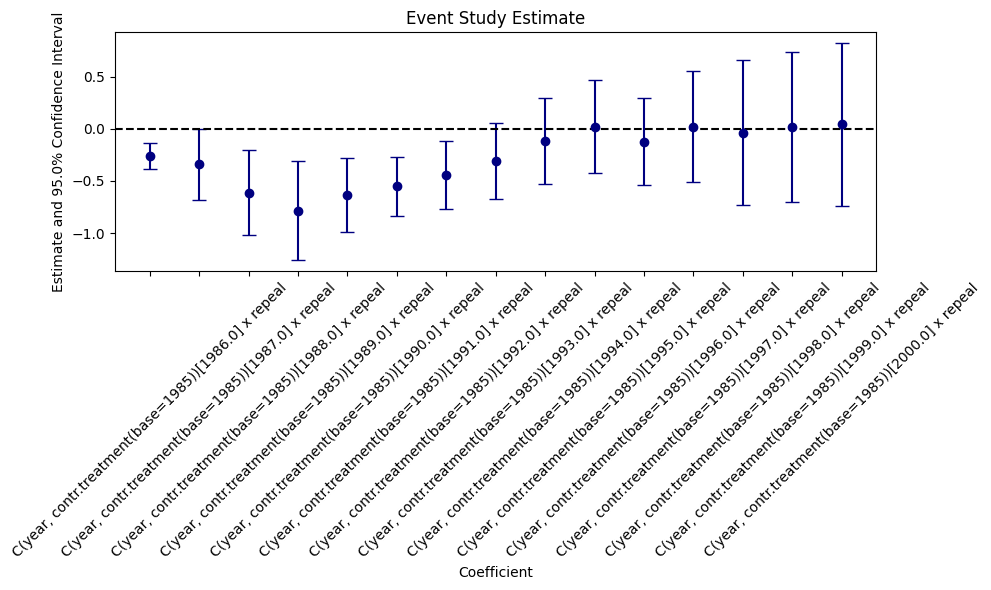

In [9]:
fml = """lnr ~ i(year, repeal, ref = 1985) + C(repeal) + C(year) + C(fip)
        + acc + ir + pi + alcohol + crack + poverty + income + ur
"""

fit = pf.feols(fml=fml, data=abortion_bf15, weights="totpop", vcov={"CRV1": "fip"})

pf.iplot(
    fit,
    coord_flip=False,
    plot_backend="matplotlib",
    rotate_xticks=45,
    title="Event Study Estimate",
    labels=_extract_bracket_numbers(fit._coefnames),
)